In [1]:
import sys
sys.path.append('../')

from lib.dataset import read_csv, Dataset

LABELS = ['antiena', 'aviena', 'jautiena', 'kalakutiena', 'kiauliena', 'versiena', 'vistiena']

train_data = read_csv(f'data/meat_train.csv')
train_set = Dataset([d for d in train_data if d.label in LABELS], train_data.label, train_data.meta)
train_labels = [sample.label for sample in train_set]

test_data = read_csv(f'data/meat_test.csv')
test_set = Dataset([d for d in test_data if d.label in LABELS], test_data.label, test_data.meta)
test_labels = [sample.label for sample in test_set]

In [2]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from time import time
import numpy as np

y_train = train_labels
x_train = train_set.intensities

y_test = test_labels
x_test = test_set.intensities

# PCA
pca = PCA(n_components=10, whiten=True)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

clf = svm.SVC(kernel='linear', C=10, class_weight='balanced')
clf.fit(x_train, y_train)

t = time()
prediction = clf.predict(x_test)
print("training time:", round(time()-t, 3), "s.")

accuracy = accuracy_score(prediction, y_test)
print("accuracy:", accuracy)

print("training score:", clf.score(x_train, y_train))
print("testing score: ", clf.score(x_test, y_test))

scores = cross_val_score(clf, x_train, y_train, cv=5)
print("cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

training time: 0.001 s.
accuracy: 0.8145695364238411
training score: 0.8789237668161435
testing score:  0.8145695364238411
cross validation score: 0.73 (+/- 0.11)


In [3]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
                   ]

clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
print(classification_report(y_test, prediction))
print()

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.269 (+/-0.007) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.269 (+/-0.007) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.540 (+/-0.075) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.269 (+/-0.007) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.704 (+/-0.097) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.536 (+/-0.079) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.740 (+/-0.089) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.704 (+/-0.101) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.747 (+/-0.078) for {'C': 1, 'kernel': 'linear'}
0.731 (+/-0.117) for {'C': 10, 'kernel': 'linear'}
0.722 (+/-0.110) for {'C': 100, 'kernel': 'linear'}
0.711 (+/-0.085) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    r

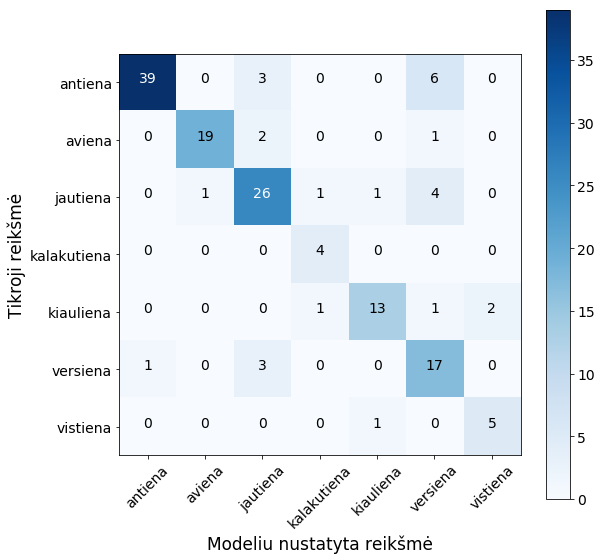

In [5]:
from sklearn.metrics import confusion_matrix
from lib.plots import plot_confusion_matrix

cm = confusion_matrix(prediction, y_test)
plot_confusion_matrix(cm, LABELS)